In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sign-language-eng-alphabet/Images/N/N_225.png
/kaggle/input/sign-language-eng-alphabet/Images/N/N_710.png
/kaggle/input/sign-language-eng-alphabet/Images/N/N_582.png
/kaggle/input/sign-language-eng-alphabet/Images/N/N_49.png
/kaggle/input/sign-language-eng-alphabet/Images/N/N_117.png
/kaggle/input/sign-language-eng-alphabet/Images/N/N_88.png
/kaggle/input/sign-language-eng-alphabet/Images/N/N_641.png
/kaggle/input/sign-language-eng-alphabet/Images/N/N_120.png
/kaggle/input/sign-language-eng-alphabet/Images/N/N_96.png
/kaggle/input/sign-language-eng-alphabet/Images/N/N_669.png
/kaggle/input/sign-language-eng-alphabet/Images/N/N_803.png
/kaggle/input/sign-language-eng-alphabet/Images/N/N_869.png
/kaggle/input/sign-language-eng-alphabet/Images/N/N_566.png
/kaggle/input/sign-language-eng-alphabet/Images/N/N_986.png
/kaggle/input/sign-language-eng-alphabet/Images/N/N_555.png
/kaggle/input/sign-language-eng-alphabet/Images/N/N_507.png
/kaggle/input/sign-language-eng-alphabet/Im

In [2]:
import os
import pathlib

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications import Xception
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator



/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# Random seed
SEED = 42

# Load dataset
train_path = "../input/sign-language-eng-alphabet/Images"
train_dir = pathlib.Path(train_path)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.3,
    rotation_range=30,
    zoom_range=[0.9, 1.1],
    horizontal_flip=True,
    vertical_flip=True,
    height_shift_range=0.2,
    width_shift_range=0.2,
    shear_range=0.2,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.3)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    subset='training',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    seed=SEED
)

valid_generator = valid_datagen.flow_from_directory(
    train_dir,
    subset='validation',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    seed=SEED
)


Found 16800 images belonging to 24 classes.
Found 7200 images belonging to 24 classes.


In [4]:
# Load class names
class_names = train_generator.class_indices
num_classes = len(class_names)
print(f'{num_classes} classes:\n{class_names}')

# Create the Xception model
base_model = Xception(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of Xception
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)

x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)

x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)

output = Dense(num_classes, activation='softmax')(x)

model_Xception = tf.keras.Model(inputs=base_model.input, outputs=output)

# Learning rate decay function
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.9,
    staircase=True
)

# Compile the model with learning rate decay
model_Xception.compile(
    optimizer=Adam(learning_rate=lr_schedule),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_Xception.summary()

# Setup callbacks: Early Stopping and Learning Rate Scheduler
cb_early_stopper = EarlyStopping(monitor='val_loss', patience=10)
lr_scheduler = LearningRateScheduler(lr_schedule)


24 classes:
{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12, 'O': 13, 'P': 14, 'Q': 15, 'R': 16, 'S': 17, 'T': 18, 'U': 19, 'V': 20, 'W': 21, 'X': 22, 'Y': 23}
83683744/83683744 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 111, 111, 32)         128       ['block1_conv1[0][0]']        
 alizati

In [5]:
# Train the model
history_model_Xception = model_Xception.fit(
    train_generator,
    epochs=10,
    workers=-1,
    validation_data=valid_generator,
    callbacks=[cb_early_stopper, lr_scheduler]
)

Epoch 1/10
525/525 [==============================] - 361s 667ms/step - loss: 1.4841 - accuracy: 0.5646 - val_loss: 0.4420 - val_accuracy: 0.8675 - lr: 0.0010
Epoch 2/10
525/525 [==============================] - 231s 440ms/step - loss: 0.8099 - accuracy: 0.7408 - val_loss: 0.3724 - val_accuracy: 0.8810 - lr: 9.0000e-04
Epoch 3/10
525/525 [==============================] - 233s 444ms/step - loss: 0.6878 - accuracy: 0.7795 - val_loss: 0.2917 - val_accuracy: 0.9118 - lr: 9.0000e-04
Epoch 4/10
525/525 [==============================] - 232s 443ms/step - loss: 0.6434 - accuracy: 0.7911 - val_loss: 0.2784 - val_accuracy: 0.9157 - lr: 8.1000e-04
Epoch 5/10
525/525 [==============================] - 237s 451ms/step - loss: 0.6177 - accuracy: 0.7977 - val_loss: 0.2420 - val_accuracy: 0.9133 - lr: 8.1000e-04
Epoch 6/10
525/525 [==============================] - 232s 442ms/step - loss: 0.5589 - accuracy: 0.8185 - val_loss: 0.2588 - val_accuracy: 0.9117 - lr: 7.2900e-04
Epoch 7/10
525/525 [======

In [6]:
# Save the model
model_Xception.save("model_Xception.h5")
print("Model Saved")


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model Saved


In [7]:
# Model evaluation and metrics calculation
def get_predictions(model, generator):
    predictions = []
    true_labels = []
    steps = generator.n // generator.batch_size
    generator.reset()
    for _ in range(steps):
        X_batch, y_batch = next(generator)
        y_pred = model.predict(X_batch)
        predictions.extend(np.argmax(y_pred, axis=1))
        true_labels.extend(np.argmax(y_batch, axis=1))
    return np.array(predictions), np.array(true_labels)

# Get predictions from the model
y_pred, y_true = get_predictions(model_Xception, valid_generator)

# Accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy: {accuracy}')


1/1 [==============================] - 0s 30ms/step
Accuracy: 0.9526388888888889


In [8]:
# Precision, Recall, F1-Score
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

# Classification Report
class_report = classification_report(y_true, y_pred)
print('Classification Report:')
print(class_report)

Precision: 0.9591633709735644
Recall: 0.9526388888888889
F1 Score: 0.9523005448751207
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       300
           1       0.99      0.64      0.78       300
           2       1.00      0.99      0.99       300
           3       0.97      0.99      0.98       300
           4       0.98      0.84      0.91       300
           5       0.74      1.00      0.85       300
           6       1.00      0.99      0.99       300
           7       1.00      1.00      1.00       300
           8       0.98      1.00      0.99       300
           9       0.96      0.93      0.95       300
          10       0.97      0.99      0.98       300
          11       1.00      0.91      0.95       300
          12       0.99      1.00      1.00       300
          13       0.93      1.00      0.96       300
          14       1.00      1.00      1.00       300
          15       1.00   

In [9]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

Confusion Matrix:
[[300   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0 193   0   0   0 107   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0 296   0   0   0   0   0   0   0   0   0   0   4   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0 298   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   2   0]
 [  0   0   0   0 252   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0  48   0]
 [  0   0   0   0   0 299   0   0   1   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0   0   0 296   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   4   0]
 [  0   0   0   0   0   0   1 299   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0 300   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0 280   0   0   0   0   0   0   0   0

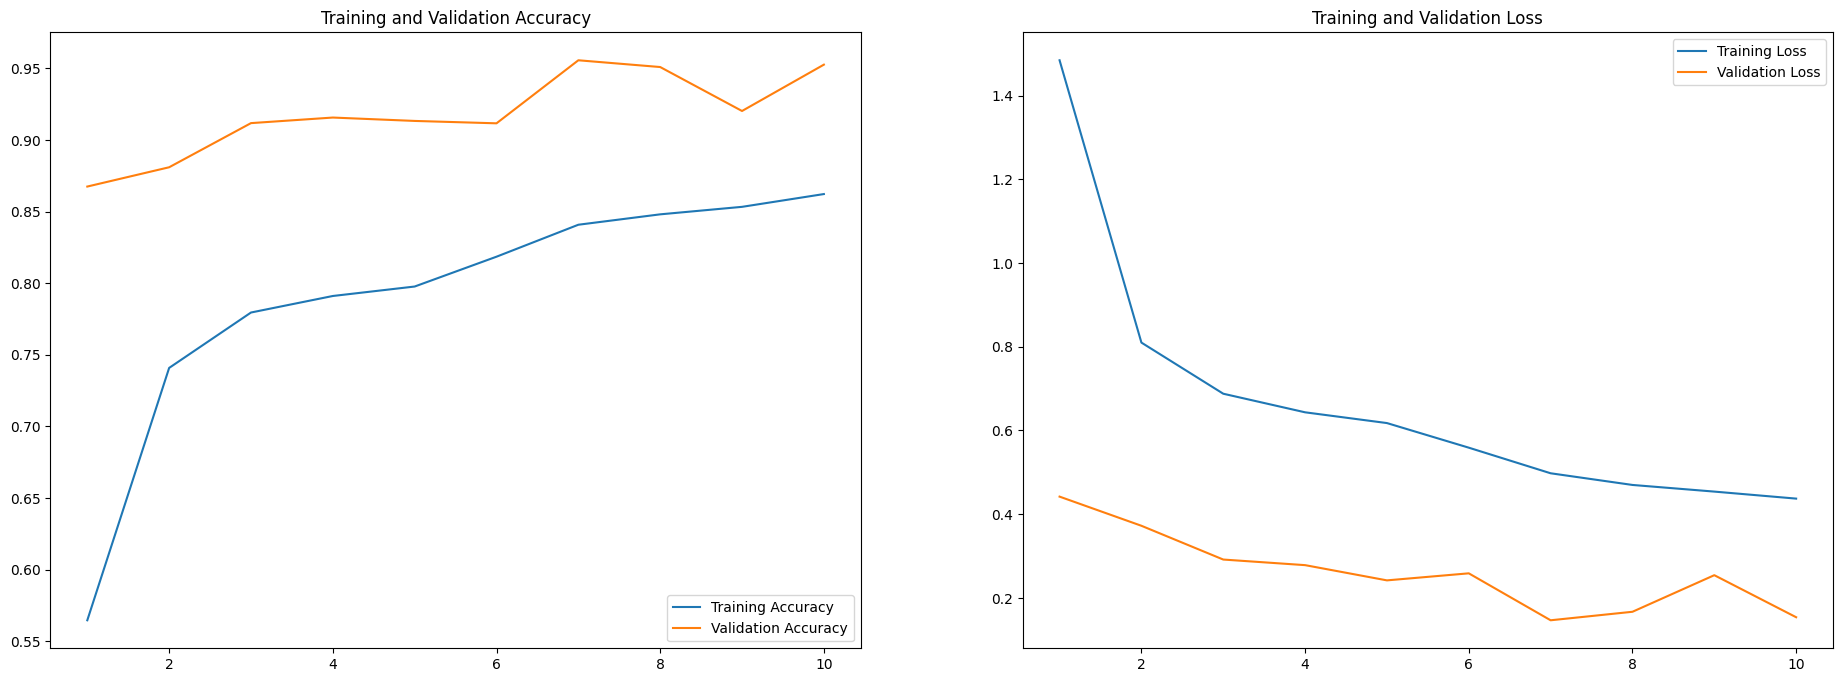

In [10]:
# Plotting results
acc = history_model_Xception.history['accuracy']
val_acc = history_model_Xception.history['val_accuracy']

loss = history_model_Xception.history['loss']
val_loss = history_model_Xception.history['val_loss']

epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(23, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()